# Plot Processed Data
---
This notebook contains code that can be used to plot different aspects of the data containing node, edge and meta information of an event after the data processing step of the edge classification pipeline.

## Imports & Global Information

In [120]:
import glob, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import torch
import pprint

# Utilities for plotting
sys.path.append("../")
from utils.plotting import (
    plot_stt,
    plot_isochrones_with_pid,
    plot_isochrones,
    plot_stt_on_ax,
)

In [121]:
# to get access to the pdg database 2024 version
import pdg

PdgApi = pdg.connect(
    "sqlite:////home/nikin105/mlProject/data/pdg/pdgall-2024-v0.1.0.sqlite"
)

## Data Input and Image Output Paths

In [122]:
channel = "XiAntiXi"
project_name = "layerwise"
event_num = 43
save_figs = True

image_dir = f"/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/{channel}/{project_name}/"
os.makedirs(image_dir, exist_ok=True)
input_dir = f"/home/nikin105/mlProject/data/machineLearning/{channel}/processed_files/{project_name}/"
proc_files = sorted(glob.glob(os.path.join(input_dir, "*")))
data = torch.load(f"{input_dir}/{event_num}", map_location="cpu")

## Inspect the Data

In [123]:
for key in data.keys:
    print(key, ":")
    if key == "event_file":
        pprint.pp(data[key])
    elif key == "multi_hit_particle_ids":
        pprint.pp(data[key][0:10])
    elif data[key].ndim == 2:
        pprint.pp(data[key][0:10, 0:10])
    else:
        pprint.pp(data[key][0:10])
    print()

pid :
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.int32)

edge_index :
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 17, 18, 33, 34, 74, 75, 76, 77, 78]])

pdgcode :
tensor([2212, 2212, 2212, 2212, 2212, 2212, 2212, 2212, 2212, 2212],
       dtype=torch.int32)

multi_hit_particle_ids :
[[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1]]

peta :
tensor([1.4439, 1.4435, 1.4429, 1.4427, 1.4420, 1.4428, 1.4425, 1.4427, 1.4396,
        1.4398], dtype=torch.float64)

true_edges :
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

x :
tensor([[0.3959, 0.4952, 0.3647],
        [0.4172, 0.4908, 0.5345],
        [0.4375, 0.4956, 0.6016],
        [0.4588, 0.4917, 0.1762],
        [0.4791, 0.4960, 0.9669],
        [0.5004, 0.4923, 0.1726],
        [0.5219, 0.4890, 0.5584],
        [0.5420, 0.4929, 0.6415],
        [0.7751, 0.4827, 0.3630],
        [0.7972, 0.4807, 0.7932]])

pphi :
tensor([3.0704, 3.0602, 3.0508, 3

In [124]:
test_connections = False

if test_connections:
    same_layer_connection_indices = []
    # check for double connections
    for i in range(len(data.edge_index[0])):
        start_index = data.edge_index[0][i]
        end_index = data.edge_index[1][i]
        if start_index == end_index:
            print(f"Self connection at index {i}")
        for j in range(len(data.edge_index[0])):
            if i != j:
                if (
                    start_index == data.edge_index[1][j]
                    and end_index == data.edge_index[0][j]
                ):
                    print(f"Both way connection at index {i} and {j}")
                    same_layer_connection_indices.append(i)
                if (
                    start_index == data.edge_index[0][j]
                    and end_index == data.edge_index[1][j]
                ):
                    print(f"Same connection at index {i} and {j}")

## Plot Graphs
---

#### Data Preparation

In [125]:
# Convert hit positions from scaled polar coordinates to cartesian coordinates
r = data.x[:, 0] * 42
phi = data.x[:, 1] * 2 * np.pi
isochrones = data.x[:, 2] * 0.5

x = r * np.cos(phi)
y = r * np.sin(phi)

# Get the number of hits
n_hits = len(data.x)

# Prepare the colors for the different pids
pid_color_palette = sns.color_palette("tab20")

# Rename some variables for better readability
gt = data.true_edges
input_edges = data.edge_index
edge_labels = data.y_pid
hid = data.hid
pids = data.pid
pdg_codes = data.pdgcode

# Get true and false input edges
true_input_edges = input_edges[:, edge_labels == 1]
false_input_edges = input_edges[:, edge_labels == 0]

# Get the unique particle ids
unique_pids = np.unique(pids)

# Get the number of multi hits per hit
n_multi_hits = data.n_multi_hits

# Get the pids of the multi hits
multi_hit_pids = data.multi_hit_particle_ids

### Ground Truth

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//gt_43.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//gt_43.pdf


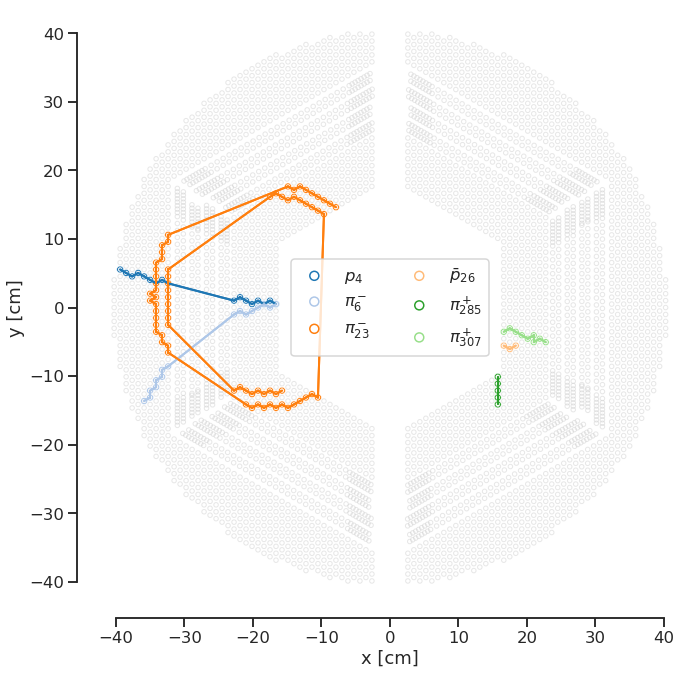

In [126]:
# prepare isochrones for the plot
isochrone_circles, legend_handles = plot_isochrones_with_pid(
    x,
    y,
    torch.tensor([0.5] * len(isochrones)),
    n_multi_hits,
    multi_hit_pids,
    hid,
    pids,
    unique_pids,
    pdg_codes,
    pid_color_palette,
    line_width=0.22,
)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)


# plot edges (divide by 2 because the graph is bidirectional)
for i_edge in range(int(len(gt[0]))):
    x_start = x[gt[0][i_edge]]
    x_end = x[gt[1][i_edge]]
    y_start = y[gt[0][i_edge]]
    y_end = y[gt[1][i_edge]]
    if n_multi_hits[gt[0][i_edge]] > 1 and n_multi_hits[gt[1][i_edge]] == 0:
        first_hit_particle_id = data.pid[gt[1][i_edge]].item()
    elif n_multi_hits[gt[0][i_edge]] == 0 and n_multi_hits[gt[1][i_edge]] > 1:
        first_hit_particle_id = data.pid[gt[0][i_edge]].item()
    elif n_multi_hits[gt[0][i_edge]] > 0 and n_multi_hits[gt[1][i_edge]] > 1:
        pids1 = multi_hit_pids[gt[0][i_edge]]
        pids2 = multi_hit_pids[gt[1][i_edge]]
        lw = 2
        for pid in pids1:
            if pid in pids2:
                ax.plot(
                    [x_start, x_end],
                    [y_start, y_end],
                    color=pid_color_palette[np.where(unique_pids == pid)[0][0]],
                    linewidth=lw,
                )
                lw -= 0.5 * lw
        continue
    else:
        first_hit_particle_id = data.pid[gt[0][i_edge]].item()

    ax.plot(
        [x_start, x_end],
        [y_start, y_end],
        color=pid_color_palette[np.where(unique_pids == first_hit_particle_id)[0][0]],
        lw=2,
    )

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

ax.legend(handles=legend_handles, loc="center", ncol=2)
fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/gt_{event_num}.png")
    plt.savefig(f"{image_dir}/gt_{event_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/gt_{event_num}.pdf")
    plt.savefig(f"{image_dir}/gt_{event_num}.pdf", dpi=300)
else:
    plt.show()

### Input Edges

#### All Edges

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//input_edges_43.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//input_edges_43.pdf


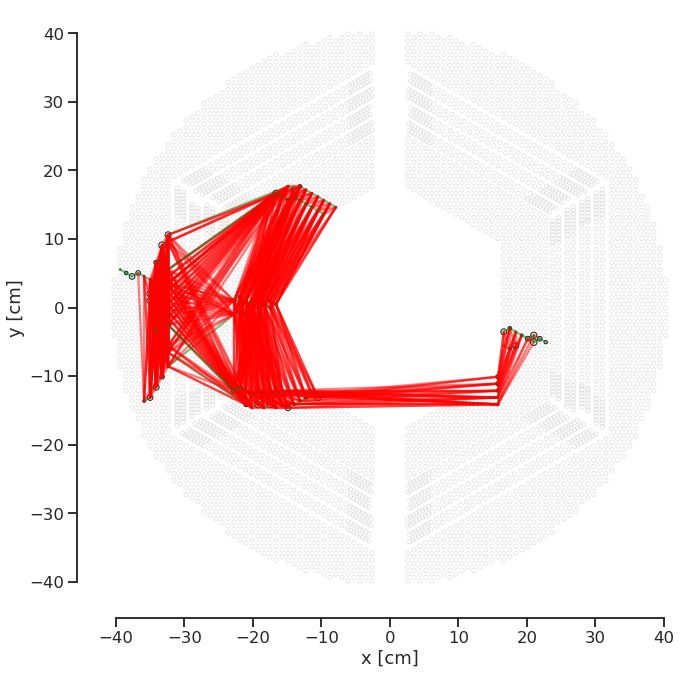

In [127]:
isochrone_circles = plot_isochrones(x, y, isochrones, hid)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

# plot edges
for i_edge in range(len(input_edges[0])):
    x_start = x[input_edges[0][i_edge]]
    x_end = x[input_edges[1][i_edge]]
    y_start = y[input_edges[0][i_edge]]
    y_end = y[input_edges[1][i_edge]]
    if edge_labels[i_edge]:
        edge_color = "green"
    else:
        edge_color = "red"
    ax.plot(
        [x_start, x_end],
        [y_start, y_end],
        color=edge_color,
        alpha=0.5,
    )

fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/input_edges_{event_num}.png")
    plt.savefig(f"{image_dir}/input_edges_{event_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/input_edges_{event_num}.pdf")
    plt.savefig(f"{image_dir}/input_edges_{event_num}.pdf", dpi=300)
else:
    plt.show()

#### Edges for One Hit

In [128]:
hit_num = 0

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//input_edges_43_hit_0.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//input_edges_43_hit_0.pdf


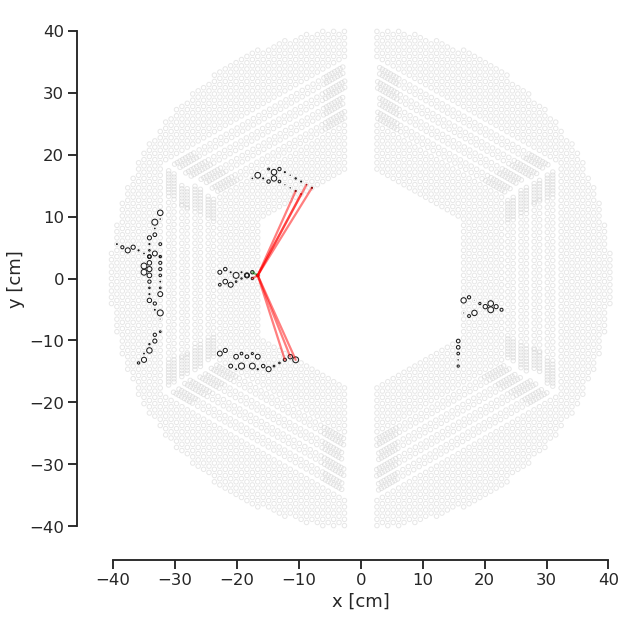

In [129]:
isochrone_circles = plot_isochrones(x, y, isochrones, hid)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

# plot edges
for i_edge in range(len(input_edges[0])):
    if input_edges[0][i_edge] == hit_num or input_edges[1][i_edge] == hit_num:
        # Define the start end end coordinates of the edge
        x_start = x[input_edges[0][i_edge]]
        x_end = x[input_edges[1][i_edge]]
        y_start = y[input_edges[0][i_edge]]
        y_end = y[input_edges[1][i_edge]]
        if edge_labels[i_edge]:
            edge_color = "green"
        else:
            edge_color = "red"
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            color=edge_color,
            alpha=0.5,
        )

if save_figs:
    print(f"Saving figure to {image_dir}/input_edges_{event_num}_hit_{hit_num}.png")
    plt.savefig(f"{image_dir}/input_edges_{event_num}_hit_{hit_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/input_edges_{event_num}_hit_{hit_num}.pdf")
    plt.savefig(f"{image_dir}/input_edges_{event_num}_hit_{hit_num}.pdf", dpi=300)
else:
    plt.show()

#### Edges for One Particle

In [130]:
particle_id = 1

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//input_edges_43_pid_1.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//input_edges_43_pid_1.pdf


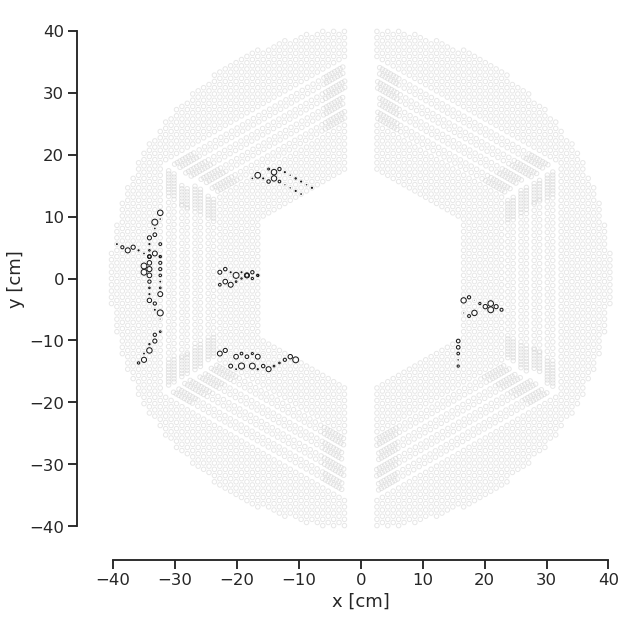

In [131]:
isochrone_circles = plot_isochrones(x, y, isochrones, hid)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

# plot edges
for i_edge in range(len(input_edges[0])):
    if (
        pids[input_edges[0][i_edge]] == particle_id
        or pids[input_edges[1][i_edge]] == particle_id
    ):
        # Define the start end end coordinates of the edge
        x_start = x[input_edges[0][i_edge]]
        x_end = x[input_edges[1][i_edge]]
        y_start = y[input_edges[0][i_edge]]
        y_end = y[input_edges[1][i_edge]]
        if edge_labels[i_edge]:
            edge_color = "green"
        else:
            edge_color = "red"
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            color=edge_color,
            alpha=0.5,
        )

if save_figs:
    print(f"Saving figure to {image_dir}/input_edges_{event_num}_pid_{particle_id}.png")
    plt.savefig(f"{image_dir}/input_edges_{event_num}_pid_{particle_id}.png", dpi=300)
    print(f"Saving figure to {image_dir}/input_edges_{event_num}_pid_{particle_id}.pdf")
    plt.savefig(f"{image_dir}/input_edges_{event_num}_pid_{particle_id}.pdf", dpi=300)
else:
    plt.show()

#### True Edges

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//true_input_edges_43.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//true_input_edges_43.pdf


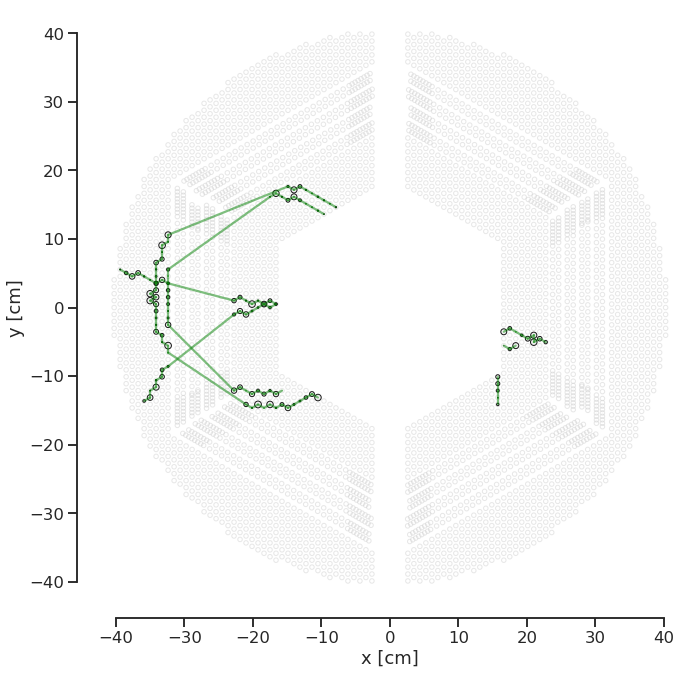

In [132]:
isochrone_circles = plot_isochrones(x, y, isochrones, hid)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

# plot edges
for i_edge in range(len(true_input_edges[0])):
    x_start = x[true_input_edges[0][i_edge]]
    x_end = x[true_input_edges[1][i_edge]]
    y_start = y[true_input_edges[0][i_edge]]
    y_end = y[true_input_edges[1][i_edge]]
    ax.plot(
        [x_start, x_end],
        [y_start, y_end],
        color="green",
        alpha=0.5,
    )

fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/true_input_edges_{event_num}.png")
    plt.savefig(f"{image_dir}/true_input_edges_{event_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/true_input_edges_{event_num}.pdf")
    plt.savefig(f"{image_dir}/true_input_edges_{event_num}.pdf", dpi=300)
else:
    plt.show()

#### False Edges

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//false_input_edges_43.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//false_input_edges_43.pdf


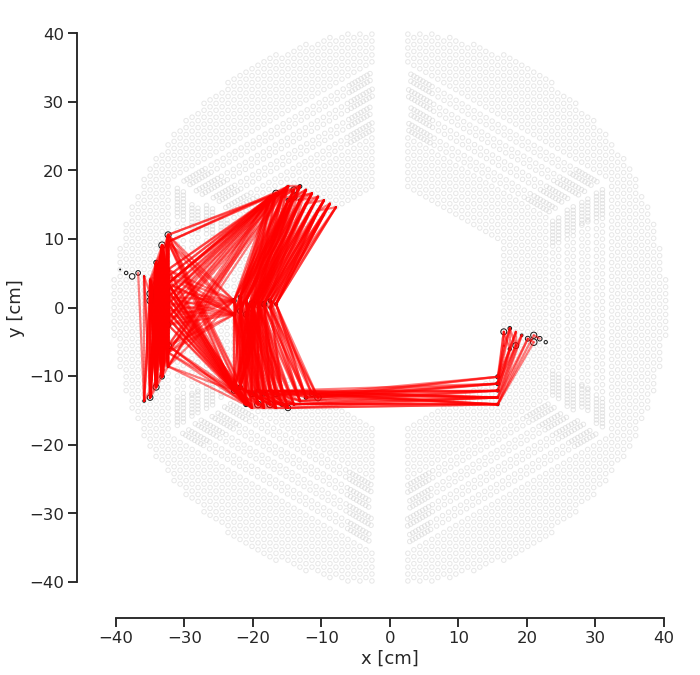

In [133]:
isochrone_circles = plot_isochrones(x, y, isochrones, hid)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

# plot edges
for i_edge in range(len(false_input_edges[0])):
    if not edge_labels[i_edge]:
        x_start = x[false_input_edges[0][i_edge]]
        x_end = x[false_input_edges[1][i_edge]]
        y_start = y[false_input_edges[0][i_edge]]
        y_end = y[false_input_edges[1][i_edge]]
        ax.plot(
            [x_start, x_end],
            [y_start, y_end],
            color="red",
            alpha=0.5,
        )

fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/false_input_edges_{event_num}.png")
    plt.savefig(f"{image_dir}/false_input_edges_{event_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/false_input_edges_{event_num}.pdf")
    plt.savefig(f"{image_dir}/false_input_edges_{event_num}.pdf", dpi=300)
else:
    plt.show()

### Missing Edges

In [134]:
# Find edges that are unique in the ground truth and the input edges
# For this step the directionality of the edges is not considered!
# This means if the ground truth contains (1,0) and the input edges only contain (0,1) it is still considered as a match
print("Number of true input edges:", len(true_input_edges[0]))
print("Number of gt edges:", len(gt[0])/2)
print("Difference:", len(true_input_edges[0]) - len(gt[0])/2)

true_input_edges_set = set(
    tuple(sorted([true_input_edges[0, i].item(), true_input_edges[1, i].item()]))
    for i in range(len(true_input_edges[0]))
)
gt_set = set(
    tuple(sorted([gt[0, i].item(), gt[1, i].item()])) for i in range(len(gt[0]))
)

unique_in_gt = gt_set - true_input_edges_set
unique_in_input_edges = true_input_edges_set - gt_set

print(f"Unique in gt: {unique_in_gt}")
print(f"Unique in input_edges: {unique_in_input_edges}")

Number of true input edges: 115
Number of gt edges: 116.0
Difference: -1.0
Unique in gt: {(76, 77)}
Unique in input_edges: set()


Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//missing_edges_43.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//missing_edges_43.pdf


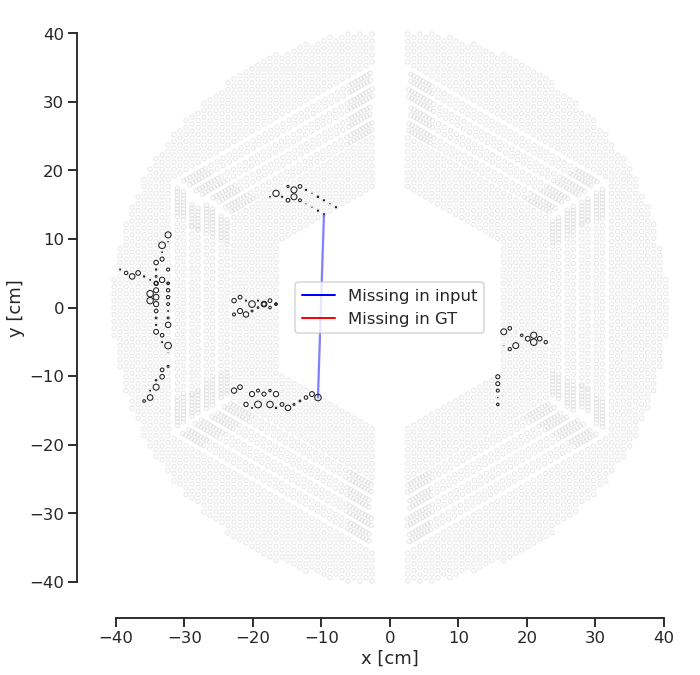

In [135]:
isochrone_circles = plot_isochrones(x, y, isochrones, hid)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

# plot edges
for edge in unique_in_gt:
    x_start = x[edge[0]]
    x_end = x[edge[1]]
    y_start = y[edge[0]]
    y_end = y[edge[1]]
    ax.plot(
        [x_start, x_end],
        [y_start, y_end],
        color="blue",
        alpha=0.5,
    )

for edge in unique_in_input_edges:
    x_start = x[edge[0]]
    x_end = x[edge[1]]
    y_start = y[edge[0]]
    y_end = y[edge[1]]
    ax.plot(
        [x_start, x_end],
        [y_start, y_end],
        color="red",
        alpha=0.5,
    )

fig.tight_layout()

# Add a legend
legend_elements = [
    Line2D([0], [0], color="blue", lw=2, label="Missing in input"),
    Line2D([0], [0], color="red", lw=2, label="Missing in GT"),
]
ax.legend(handles=legend_elements, loc="center")

if save_figs:
    print(f"Saving figure to {image_dir}/missing_edges_{event_num}.png")
    plt.savefig(f"{image_dir}/missing_edges_{event_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/missing_edges_{event_num}.pdf")
    plt.savefig(f"{image_dir}/missing_edges_{event_num}.pdf", dpi=300)
else:
    plt.show()

## Event wise Hit & Edge Information

In [136]:
event_info = pd.read_hdf(
    f"/home/nikin105/mlProject/data/machineLearning/{channel}/processed_files/{project_name}/event_info.h5"
)

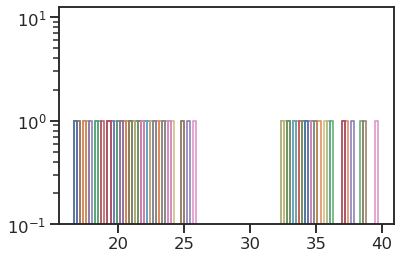

In [137]:
plt.hist(r,histtype="step", bins=100)
plt.yscale("log")
plt.ylim(0.1, None)
plt.show()

### Inspect the Data

In [138]:
event_info.head()

,event_id,n_true_edges,n_input_edges,n_true_input_edges,n_false_input_edges,n_hits,n_zero_charge_hits,n_multi_hits,missing_true_edges
0,0,49,128,49,79,53,0,0,0
1,1,38,149,38,111,40,0,0,0
2,2,19,127,19,108,23,0,0,0
3,3,106,1105,103,1002,109,0,0,3
4,4,61,242,61,181,67,0,0,0


In [139]:
max_missing_edges = event_info.missing_true_edges.max()
max_missing_edges_events = event_info.event_id[
    event_info.missing_true_edges == max_missing_edges
].values

max_multi_hits = event_info.n_multi_hits.max()
max_multi_hits_events = event_info.event_id[
    event_info.n_multi_hits == max_multi_hits
].values

max_zero_charge_hits = event_info.n_zero_charge_hits.max()
max_zero_charge_hits_events = event_info.event_id[
    event_info.n_zero_charge_hits == max_zero_charge_hits
].values

print(
    f"Event(s) {max_missing_edges_events} has(have) the most missing edges with {max_missing_edges} missing edges"
)

print(
    f"Event(s) {max_multi_hits_events} has(have) the most multi hits with {max_multi_hits} multi hits"
)

print(
    f"Event(s) {max_zero_charge_hits_events} has(have) the most zero charge hits with {max_zero_charge_hits} zero charge hits"
)
print(
    "Percentage of true edges in the input graph:",
    event_info.n_true_input_edges.sum() / event_info.n_input_edges.sum() * 100,
    "%",
)
print(
    "Percentage of false edges in the input graph:",
    event_info.n_false_input_edges.sum() / event_info.n_input_edges.sum() * 100,
    "%",
)
print(
    "Percentage of ground truth edges in the true input graph:",
    event_info.n_true_input_edges.sum() / event_info.n_true_edges.sum() * 100,
    "%",
)
print("Mean number of hits per event:", event_info.n_hits.mean())
print("Mean number of multi hit events per data set:", len(event_info[event_info.n_multi_hits==1])/len(event_info))
print(
    "Mean number of zero charge hits per event:", event_info.n_zero_charge_hits.mean()
)
print("Mean number of input edges per event:", event_info.n_input_edges.mean())
print("Mean number of true edges per event:", event_info.n_true_input_edges.mean())
print("Mean number of false edges per event:", event_info.n_false_input_edges.mean())

Event(s) [ 4119 10736] has(have) the most missing edges with 9 missing edges
Event(s) [72847] has(have) the most multi hits with 52 multi hits
Event(s) [34255 35409] has(have) the most zero charge hits with 3 zero charge hits
Percentage of true edges in the input graph: 18.307804109612942 %
Percentage of false edges in the input graph: 81.69219589038705 %
Percentage of ground truth edges in the true input graph: 99.44563381324596 %
Mean number of hits per event: 57.53441
Mean number of multi hit events per data set: 0.00931
Mean number of zero charge hits per event: 0.02932
Mean number of input edges per event: 293.43104
Mean number of true edges per event: 53.72078
Mean number of false edges per event: 239.71026


In [140]:
data = torch.load(f"{input_dir}/33", map_location="cpu")

### Plot Tracks with Multi-Hits

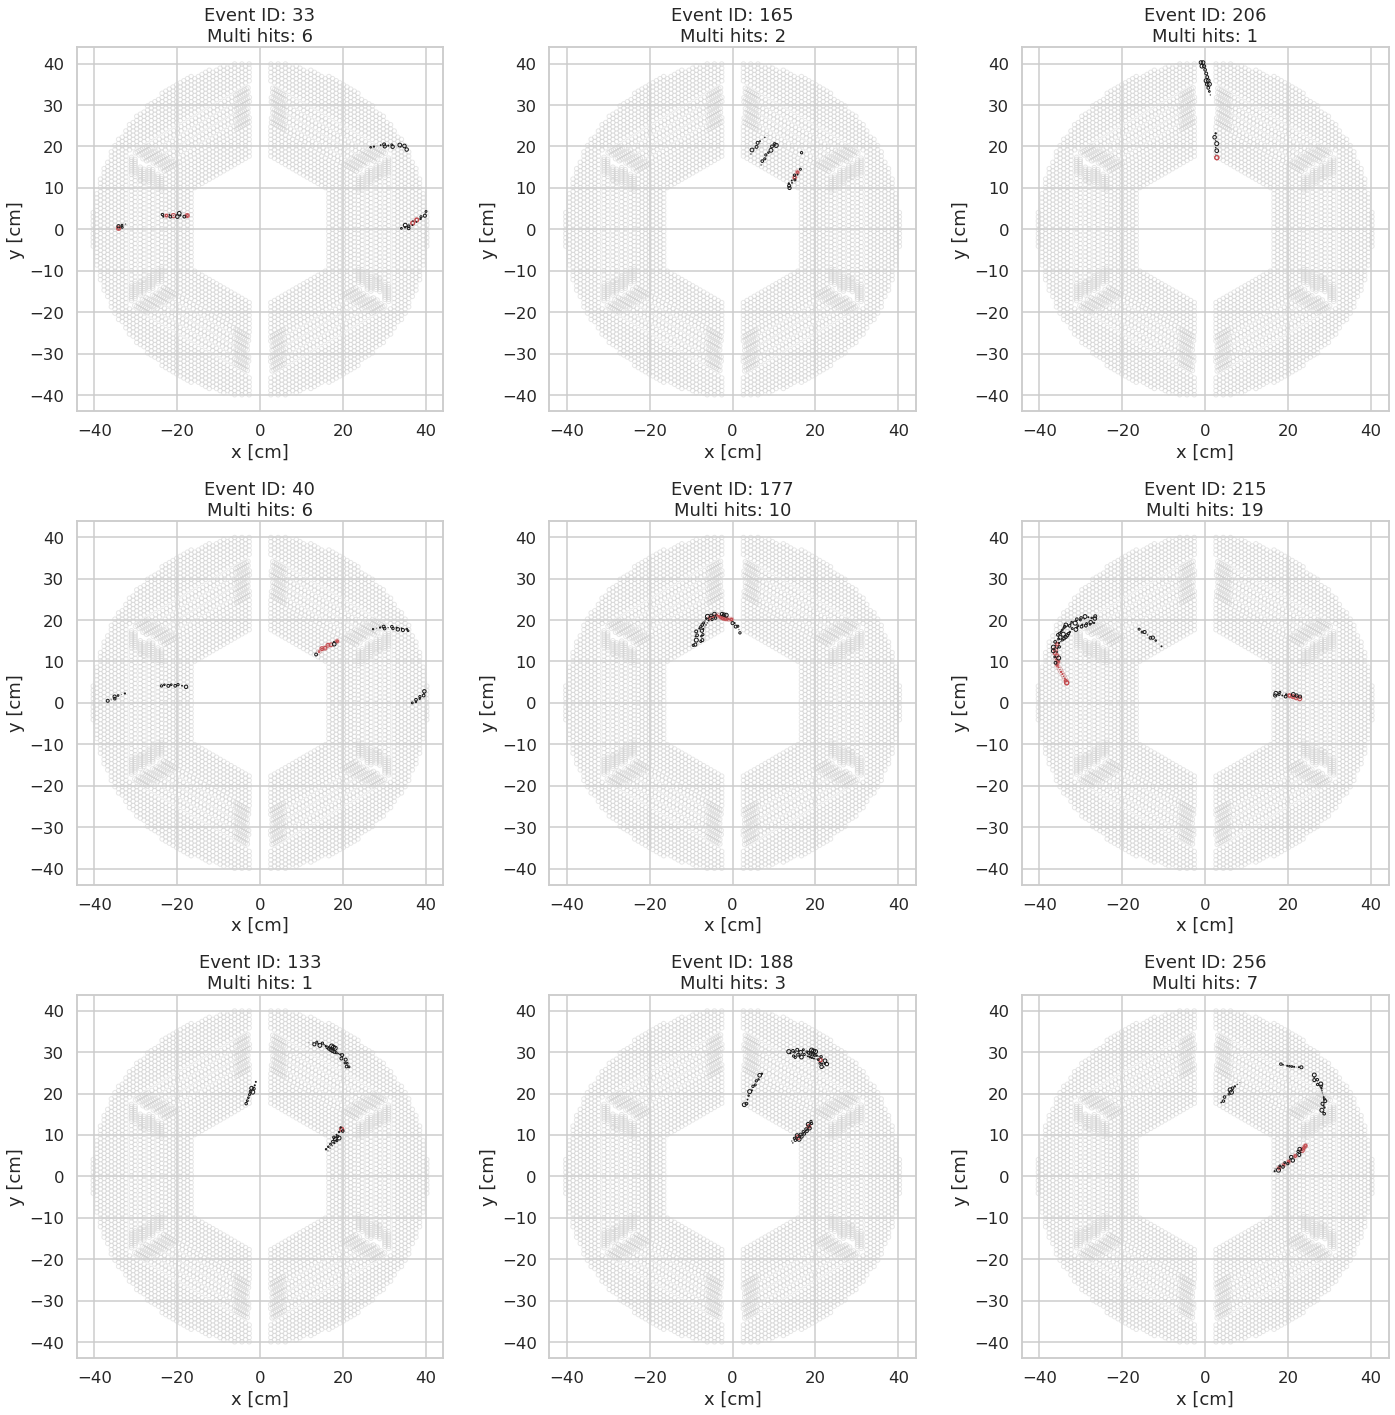

In [141]:
multi_hit_event_ids = event_info.query("n_multi_hits > 0").event_id.values
n_multi_hits_per_event = event_info.query("n_multi_hits > 0").n_multi_hits.values

plt.close("all")
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

row = 0
col = 0
event = 0
for event_id in multi_hit_event_ids[:9]:
    data = torch.load(f"{input_dir}/{event_id}", map_location="cpu")
    # Convert hit positions from scaled polar coordinates to cartesian coordinates
    r = data.x[:, 0] * 42
    phi = data.x[:, 1] * np.pi
    isochrones = data.x[:, 2] * 0.5

    x = r * np.cos(phi)
    y = r * np.sin(phi)

    # Get the number of hits
    n_hits = len(data.x)

    # Rename some variables for better readability
    hid = data.hid
    pids = data.pid
    pdg_codes = data.pdgcode

    df = pd.DataFrame(
        {"hid": hid, "pid": pids, "x": x, "y": y, "isochrone": isochrones},
        index=None,
    )
    df["duplicate"] = df.duplicated(subset=["x", "y", "pid"], keep=False)

    # Get the unique particle ids
    unique_pids = np.unique(pids)

    # plotting

    plot_stt_on_ax(ax[row][col], useGrayScale=True, alpha=0.5)

    # plot nodes
    for pid in df[df.duplicate].pid.unique():
        multi_hit_hit_ids = df[df.pid == pid][df.duplicate[df.pid == pid]].hid.values
        other_hit_ids = df[df.pid == pid][df.duplicate[df.pid == pid] == 0].hid.values
        multi_hit_isochrone_circles = plot_isochrones(
            x, y, isochrones, multi_hit_hit_ids, "r"
        )
        for circle in multi_hit_isochrone_circles:
            ax[row][col].add_artist(circle)
        ax[row][col].scatter(
            df[df.pid == pid][df.duplicate[df.pid == pid]].x,
            df[df.pid == pid][df.duplicate[df.pid == pid]].y,
            s=25,
            fc="none",
            ec="r",
            lw=0.1,
        )
        other_isochrone_circles = plot_isochrones(x, y, isochrones, other_hit_ids, "k")
        for circle in other_isochrone_circles:
            ax[row][col].add_artist(circle)

    ax[row][col].set_title(
        f"Event ID: {event_id}\nMulti hits: {n_multi_hits_per_event[event]}",
    )

    row += 1
    if row == 3:
        row = 0
        col += 1
    event += 1

fig.tight_layout()

if not save_figs:
    print(f"Saving figure to {image_dir}/multi_hit.png")
    plt.savefig(f"{image_dir}/multi_hit.png", dpi=300)
    print(f"Saving figure to {image_dir}/multi_hit.pdf")
    plt.savefig(f"{image_dir}/multi_hit.pdf", dpi=300)
else:
    plt.show()

### Plot Tracks with Zero Deposited Charge

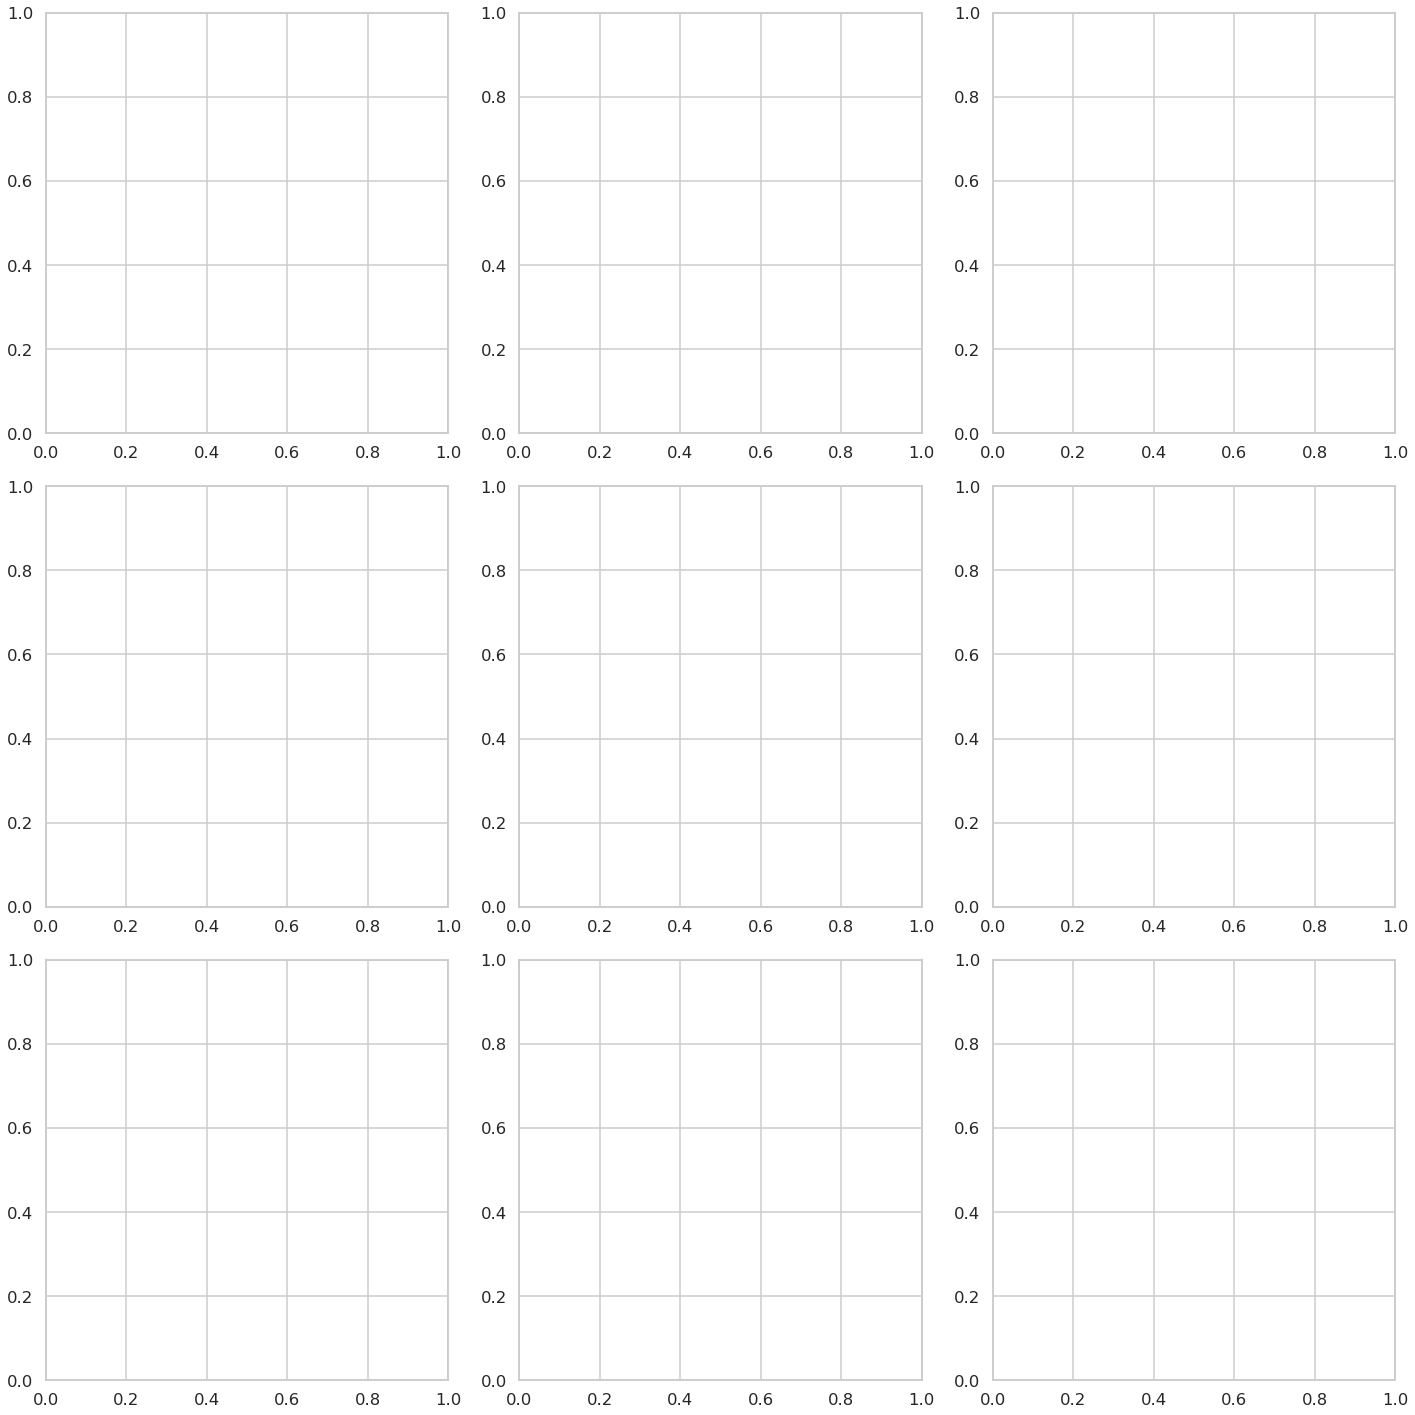

In [142]:
zero_dep_charge_events = event_info.query("n_zero_charge_hits > 0").event_id.values
zero_dep_charge_events = []
n_zero_dep_charge_per_events = event_info.query(
    "n_zero_charge_hits > 0"
).n_zero_charge_hits.values

plt.close("all")
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

row = 0
col = 0
event = 0
for event_id in zero_dep_charge_events[:9]:
    data = torch.load(f"{input_dir}/{event_id}", map_location="cpu")
    # Convert hit positions from scaled polar coordinates to cartesian coordinates
    r = data.x[:, 0] * 100
    phi = data.x[:, 1] * np.pi
    isochrones = data.x[:, 2] * 100
    dep_charge = data.x[:, 3]

    x = r * np.cos(phi)
    y = r * np.sin(phi)

    # Get the number of hits
    n_hits = len(data.x)

    # Rename some variables for better readability
    hid = data.hid
    pids = data.pid
    pdg_codes = data.pdgcode

    df = pd.DataFrame(
        {
            "hid": hid,
            "pid": pids,
            "x": x,
            "y": y,
            "isochrone": isochrones,
            "dep_charge": dep_charge,
        },
        index=None,
    )

    # Get the unique particle ids
    unique_pids = np.unique(pids)

    # plotting

    plot_stt_on_ax(ax[row][col], useGrayScale=True, alpha=0.5)

    # plot nodes
    for pid in df[df.dep_charge == 0].pid.unique():
        dep_charge_0_hit_ids = df[df.pid == pid][
            df.dep_charge[df.pid == pid] == 0
        ].hid.values
        other_hit_ids = df[df.pid == pid][df.dep_charge[df.pid == pid] != 0].hid.values
        ax[row][col].scatter(
            df[df.pid == pid][df.dep_charge[df.pid == pid] == 0].x,
            df[df.pid == pid][df.dep_charge[df.pid == pid] == 0].y,
            s=25,
            fc="none",
            ec="b",
            lw=0.1,
        )
        dep_charge_0_isochrone_circles = plot_isochrones(
            x, y, isochrones, dep_charge_0_hit_ids, "r"
        )
        for circle in dep_charge_0_isochrone_circles:
            ax[row][col].add_artist(circle)
        other_isochrone_circles = plot_isochrones(x, y, isochrones, other_hit_ids, "k")
        for circle in other_isochrone_circles:
            ax[row][col].add_artist(circle)

    ax[row][col].set_title(
        f"Event ID: {event_id}\nZero charge hits: {n_zero_dep_charge_per_events[event]}",
    )

    row += 1
    if row == 3:
        row = 0
        col += 1
    event += 1

fig.tight_layout()

if not save_figs:
    print(f"Saving figure to {image_dir}/zero_dep_charge_hit.png")
    plt.savefig(f"{image_dir}/zero_dep_charge_hit.png", dpi=300)
    print(f"Saving figure to {image_dir}/zero_dep_charge_hit.pdf")
    plt.savefig(f"{image_dir}/zero_dep_charge_hit.pdf", dpi=300)
else:
    plt.show()

### Plot Hit & Edge Distributions

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_hits_hist.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_hits_hist.pdf


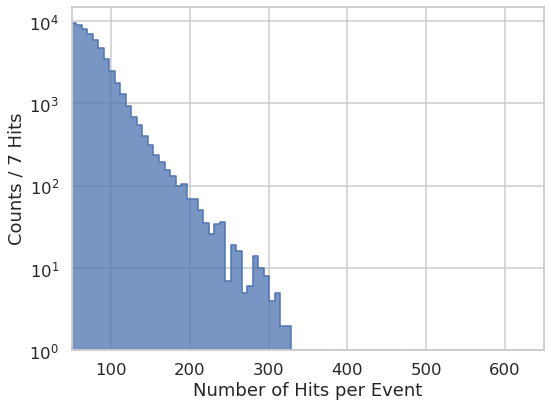

In [143]:
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(0, 700, 101)
bin_width = bins[1] - bins[0]
sns.histplot(event_info.n_hits.values, bins=bins, element="step", ax=ax)
ax.set_yscale("log")
ax.set_ylim(
    1,
)
ax.set_xlim(50, 650)
ax.set_xlabel("Number of Hits per Event")
ax.set_ylabel(f"Counts / {bin_width:.0f} Hits")

fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/n_hits_hist.png")
    plt.savefig(f"{image_dir}/n_hits_hist.png", dpi=300)
    print(f"Saving figure to {image_dir}/n_hits_hist.pdf")
    plt.savefig(f"{image_dir}/n_hits_hist.pdf", dpi=300)
else:
    plt.show()

Bin widht: 6.0
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_edges_hist.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_edges_hist.pdf


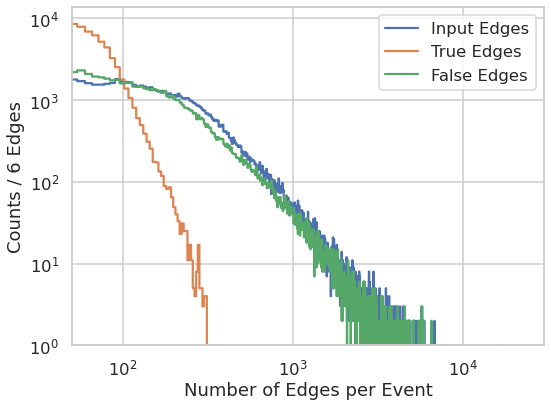

In [144]:
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(0, 30000, 5001)
bin_width = bins[1] - bins[0]
print("Bin widht:", bin_width)
sns.histplot(
    event_info,
    x="n_input_edges",
    bins=bins,
    element="step",
    ax=ax,
    fill=False,
    label="Input Edges",
)
sns.histplot(
    event_info,
    x="n_true_input_edges",
    bins=bins,
    element="step",
    ax=ax,
    fill=False,
    label="True Edges",
)
sns.histplot(
    event_info,
    x="n_false_input_edges",
    bins=bins,
    element="step",
    ax=ax,
    fill=False,
    label="False Edges",
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(
    1,
)
ax.set_xlim(50, 3e4)
ax.set_xlabel("Number of Edges per Event")
ax.set_ylabel(f"Counts / {bin_width:.0f} Edges")

ax.legend()
fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/n_edges_hist.png")
    plt.savefig(f"{image_dir}/n_hits_hist.png", dpi=300)
    print(f"Saving figure to {image_dir}/n_edges_hist.pdf")
    plt.savefig(f"{image_dir}/n_hits_hist.pdf", dpi=300)
else:
    plt.show()

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//scatter_hits_vs_edges.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//scatter_hits_vs_edges.pdf


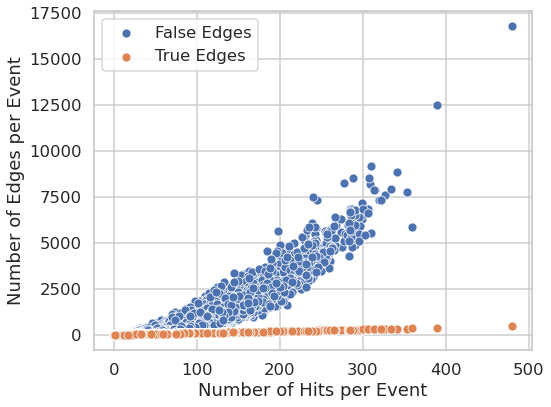

In [145]:
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=event_info, x="n_hits", y="n_false_input_edges", ax=ax, label="False Edges"
)
sns.scatterplot(
    data=event_info, x="n_hits", y="n_true_input_edges", ax=ax, label="True Edges"
)
ax.set_xlabel("Number of Hits per Event")
ax.set_ylabel(f"Number of Edges per Event")
ax.legend()
fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/scatter_hits_vs_edges.png")
    plt.savefig(f"{image_dir}/scatter_hits_vs_edges.png", dpi=300)
    print(f"Saving figure to {image_dir}/scatter_hits_vs_edges.pdf")
    plt.savefig(f"{image_dir}/scatter_hits_vs_edges.pdf", dpi=300)
else:
    plt.show()

Bin widht: 1.0
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_hits_hist.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_hits_hist.pdf


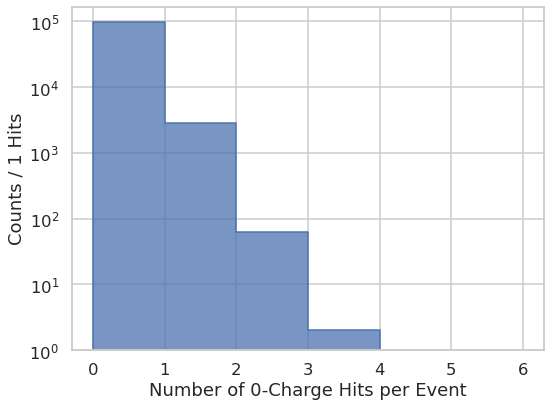

In [146]:
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(0, 6, 7)
bin_width = bins[1] - bins[0]
print("Bin widht:", bin_width)
sns.histplot(event_info.n_zero_charge_hits.values, bins=bins, element="step", ax=ax)
ax.set_yscale("log")
ax.set_ylim(
    1,
)
ax.set_xlabel("Number of 0-Charge Hits per Event")
ax.set_ylabel(f"Counts / {bin_width:.0f} Hits")

fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/n_hits_hist.png")
    plt.savefig(f"{image_dir}/n_hits_hist.png", dpi=300)
    print(f"Saving figure to {image_dir}/n_hits_hist.pdf")
    plt.savefig(f"{image_dir}/n_hits_hist.pdf", dpi=300)
else:
    plt.show()

Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_hits_hist.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/XiAntiXi/layerwise//n_hits_hist.pdf


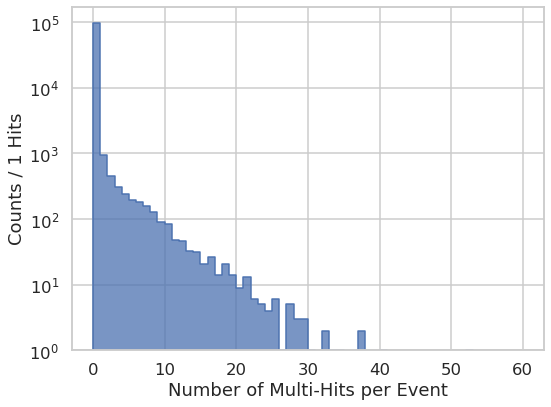

In [147]:
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(0, 60, 61)
bin_width = bins[1] - bins[0]
sns.histplot(event_info.n_multi_hits.values, bins=bins, element="step", ax=ax)
ax.set_yscale("log")
ax.set_ylim(
    1,
)
ax.set_xlabel("Number of Multi-Hits per Event")
ax.set_ylabel(f"Counts / {bin_width:.0f} Hits")

fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/n_hits_hist.png")
    plt.savefig(f"{image_dir}/n_hits_hist.png", dpi=300)
    print(f"Saving figure to {image_dir}/n_hits_hist.pdf")
    plt.savefig(f"{image_dir}/n_hits_hist.pdf", dpi=300)
else:
    plt.show()